In [1]:
#Requiered libraries
import pandas as pd
import os
import numpy as np
from datetime import date
import datetime
from keras.utils import image_dataset_from_directory
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast 
from tensorflow.keras.layers import RandomTranslation

# For evaluating performance
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

#Tensorboard
import io
import itertools
from packaging import version
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
import tensorflow as tf
import datetime
%load_ext tensorboard

In [10]:
#Reading the dataset


DATE= date.today().strftime("%Y_%m_%d")
#DATASET_PATH_train = "\05_data\original_data\2.1.1 New Plant Diseases\train"
DATASET_PATH_train ="/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/train"
#DATASET_PATH_valid = "\05_data\original_data\2.1.1 New Plant Diseases\valid
DATASET_PATH_valid = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/original_data/2.1.1 New Plant Diseases/valid"
#Constant variables

IMAGE_SIZE = (224, 224, 3)
vector_size_1D = IMAGE_SIZE[0] * IMAGE_SIZE[1] * IMAGE_SIZE[2]  # Flattened size for each image
batch_size = 64

train = image_dataset_from_directory(
    DATASET_PATH_train,  # Path to the dataset
    labels='inferred',  # Automatically infer labels from subdirectory names
    #label_mode='categorical',  # Use categorical labels
    image_size=IMAGE_SIZE[:2],  # Resize images to the specified size
    batch_size=batch_size,  # Number of images per batch
    seed=42,  # Random seed for reproducibility
    )

class_names = train.class_names #Saves all class names in a list 
classes_healthy = [class_name for class_name in train.class_names if "healthy" in class_name.lower()]
classes_sick = [class_name for class_name in train.class_names if "healthy" not in class_name.lower()]

# Validation dataset
valid = image_dataset_from_directory(
    DATASET_PATH_valid,  # Path to the dataset
    labels='inferred',  # Automatically infer labels from subdirectory names
    #label_mode='categorical',  # Use categorical labels
    image_size=IMAGE_SIZE[:2],  # Resize images to the specified size
    batch_size=batch_size,  # Number of images per batch
    seed=42,  # Random seed for reproducibility
    )

dataset = train #Choose the dataset to work with, e.g., train, valid, test_healthy, test_sick
dataset_valid = valid #Choose the dataset to work with, e.g., train, valid, test_healthy, test_sick
dataset.class_names = sorted(dataset.class_names)  # Sort class names for consistency

# Configuration for performance optimization
# This is used to optimize the performance of data loading and preprocessing
AUTOTUNE = tf.data.AUTOTUNE
# Apply performance optimizations to the datasets
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
dataset_valid = dataset_valid.cache().prefetch(buffer_size=AUTOTUNE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [11]:
from tensorflow.keras.models import load_model
# Passen Sie den Import an Ihr verwendetes Modell an, z.B.:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/models/2025_07_31_plant_classifier_fine_tuned__model.keras"

# Übergeben Sie die Funktion als 'custom_object'
model = load_model(
    model_path,
    custom_objects={'preprocess_input': preprocess_input}
)

print("Model loaded successfully!")

Model loaded successfully!


2025-08-05 09:59:50.403954: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       504
           1       0.99      1.00      1.00       497
           2       1.00      1.00      1.00       440
           3       1.00      0.99      0.99       502
           4       1.00      1.00      1.00       454
           5       1.00      0.99      1.00       421
           6       1.00      1.00      1.00       456
           7       0.97      0.94      0.95       410
           8       0.99      1.00      0.99       477
           9       0.95      0.97      0.96       477
          10       1.00      1.00      1.00       465
          11       0.99      0.99      0.99       472
          12       0.99      1.00      0.99       480
          13       1.00      1.00      1.00       430
          14       1.00      1.00      1.00       423
          15       1.00      1.00      1.00       503
          16       1.00      0.99      0.99       459
          17       1.00    

<Axes: >

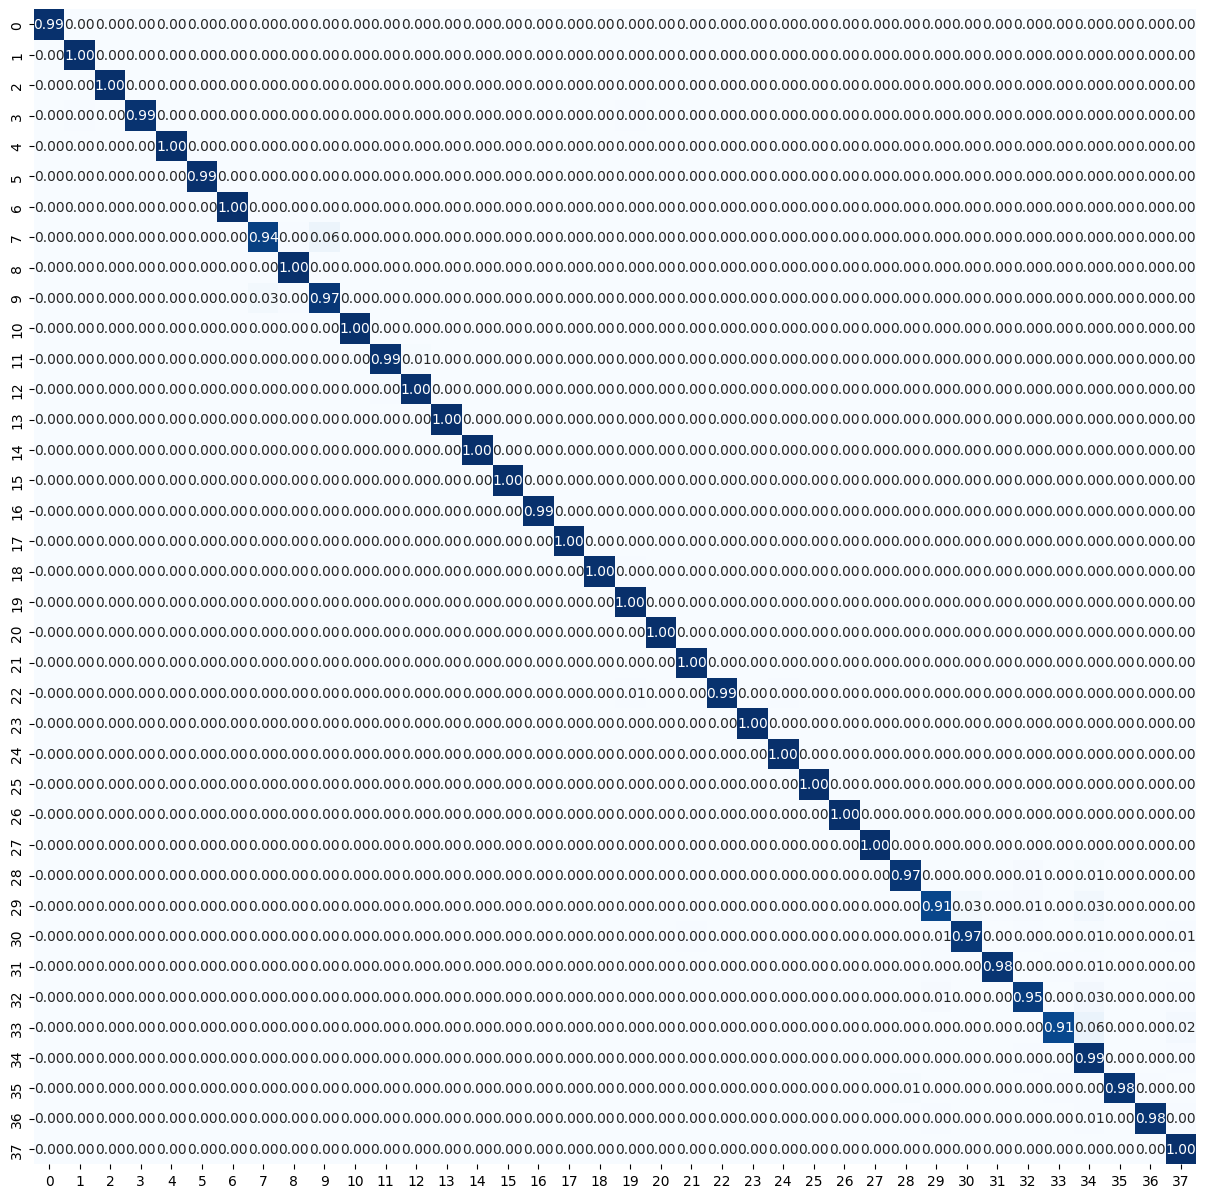

In [12]:
# Create evaluation data
#Just run

def get_predictions_and_labels(dataset):
    true_labels = []
    pred_labels = []

    for images, labels in dataset:
        
        preds = model.predict(images, verbose=0)  # Get the model's predictions
        pred_labels.extend(np.argmax(preds, axis=-1))  # Get the predicted labels (argmax)

        true_labels.extend(labels.numpy())  # Get the true labels

    return np.array(true_labels), np.array(pred_labels)

def generate_classification_report(y_true, y_pred):
    return classification_report(y_true, y_pred, output_dict=True)

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Normalized Confusion Matrix")
    return fig


y_true, y_pred = get_predictions_and_labels(dataset_valid)  # Get true labels and predictions from the test dataset

# Display the classification report
print(classification_report(y_true, y_pred))  # Print the classification report (precision, recall, F1-score)

# Display the confusion matrix
plt.figure(figsize=(15, 15))  # Create a large figure for the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred, normalize='true')  # Compute the normalized confusion matrix
sns.heatmap(cnf_matrix, cmap='Blues', annot=True, cbar=False, fmt=".2f")  # Plot the confusion matrix as a heatmap

In [30]:

report = classification_report(y_true, y_pred, output_dict=True)
cmatrix = confusion_matrix(y_true, y_pred, normalize='true')

report_file = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/05_data/models/Advanced_Model_advanced_model_classification_results.pkl"

with open(report_file, "wb") as f:
    pickle.dump({
        "y_true": y_true,
        "y_pred": y_pred,
        "report": report,
        "confusion_matrix": cmatrix
    }, f)


In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import os
from collections import defaultdict

# #######################################################################
# 1. HELFERFUNKTION
# #######################################################################

def format_class_name(label):
    """Formatiert den Klassennamen für eine bessere Lesbarkeit im Titel."""
    plant, disease = label.split("___")
    return f"{plant} ({disease.replace('_', ' ')})"

# #######################################################################
# 2. KORRIGIERTE GRAD-CAM FUNKTION
# #######################################################################

def grad_cam(image, model, base_model_name, conv_layer_name):
    """
    Berechnet Grad-CAM robust für Transfer-Learning-Modelle durch manuelle
    Rekonstruktion des Graphen.
    """
    # 1. Basismodell und Ziel-Layer holen
    base_model = model.get_layer(base_model_name)
    conv_layer = base_model.get_layer(conv_layer_name)

    # 2. Bild vorbereiten
    img_array_expanded = tf.expand_dims(image, axis=0)
    preprocessed_img = preprocess_input(tf.cast(img_array_expanded, dtype=tf.float32))

    # 3. Temporäres Modell erstellen, das den Graphen korrekt nachzeichnet
    intermediate_model = Model(inputs=base_model.inputs, outputs=[conv_layer.output, base_model.output])

    # 4. Gradienten mit dem vollständigen Graphen berechnen
    with tf.GradientTape() as tape:
        conv_outputs, base_model_output = intermediate_model(preprocessed_img)

        # WICHTIG: Stellen Sie sicher, dass diese Layernamen mit Ihrer `model.summary()` übereinstimmen!
        try:
            x = model.get_layer('global_average_pooling2d')(base_model_output)
            x = model.get_layer('dropout')(x)
            predictions = model.get_layer('dense')(x)
        except ValueError as e:
            print(f"FEHLER: Einer der Layer nach dem Basismodell wurde nicht gefunden. Überprüfen Sie die Namen in `model.summary()`.")
            raise e

        predicted_class_idx = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class_idx]

    grads = tape.gradient(loss, conv_outputs)

    # 5. Heatmap berechnen und überlagern
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)

    if tf.math.reduce_max(heatmap) > 0:
        heatmap /= tf.math.reduce_max(heatmap)

    heatmap = heatmap.numpy()

    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (image.shape[0], image.shape[1])).numpy()
    heatmap_squeezed = np.squeeze(heatmap_resized, axis=-1)
    heatmap_colored = plt.cm.jet(heatmap_squeezed)[..., :3]

    superimposed_image = heatmap_colored * 0.5 + (image / 255.0)

    return np.clip(superimposed_image, 0, 1), predicted_class_idx.numpy()

# #######################################################################
# 3. FINALE VISUALISIERUNGSFUNKTION
# #######################################################################

def show_grad_cam_with_overlay(images, labels, model, class_names, save_dir=None, base_model_name='mobilenetv2_1.00_224'):
    """
    Zeigt für jede Klasse ein Bild mit Grad-CAM-Overlay an und speichert es optional.
    """
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    try:
        base_model = model.get_layer(base_model_name)
        conv_layers = [layer.name for layer in base_model.layers if isinstance(layer, Conv2D)]
        if not conv_layers:
            print(f"Fehler: Kein Conv2D Layer im Basismodell '{base_model_name}' gefunden.")
            return
        last_conv_layer_name = conv_layers[-1]
        print(f"Verwende Layer '{last_conv_layer_name}' für Grad-CAM.")
    except ValueError:
        print(f"Fehler: Basismodell '{base_model_name}' nicht gefunden.")
        return

    images_by_class = defaultdict(lambda: {'image': None, 'label': None})
    for img, label_idx in zip(images, labels):
        if images_by_class[label_idx]['image'] is None:
            images_by_class[label_idx]['image'] = img
            images_by_class[label_idx]['label'] = label_idx

    num_classes_to_show = len(images_by_class)
    if num_classes_to_show == 0:
        print("Keine Bilder zum Anzeigen gefunden.")
        return
        
    plt.figure(figsize=(15, 5 * num_classes_to_show))

    class_items = sorted(images_by_class.items())

    for i, (label_idx, data) in enumerate(class_items):
        img = data['image']
        grad_cam_image, predicted_class_idx = grad_cam(img, model, base_model_name, last_conv_layer_name)

        true_label_str = format_class_name(class_names[label_idx])
        predicted_label_str = format_class_name(class_names[predicted_class_idx])

        plt.subplot(num_classes_to_show, 1, i + 1)
        plt.title(f'True: {true_label_str}\nPred: {predicted_label_str}', fontsize=12)
        plt.imshow(grad_cam_image)
        plt.axis("off")

        if save_dir:
            filename = f"{class_names[label_idx]}.jpg"
            filepath = os.path.join(save_dir, filename)
            gradcam_uint8 = (grad_cam_image * 255).astype(np.uint8)
            Image.fromarray(gradcam_uint8).save(filepath)
            print(f"Gespeichert: {filepath}")

    plt.tight_layout()
    plt.show()

# #######################################################################
# 4. DATEN LADEN & FINALER AUFRUF (Beispiel)
# #######################################################################

# ANNAHME: Die Variablen `model`, `class_names`, und `dataset_valid`
#          sind bereits aus dem Training Ihres Modells vorhanden.

# Sammeln von einem repräsentativen Bild pro Klasse aus dem Validierungsdatensatz
images_by_class_collector = defaultdict(list)
num_samples_per_class = 1

for images_batch, labels_batch in dataset_valid:
    for img, label in zip(images_batch, labels_batch):
        label_int = int(label.numpy())
        if len(images_by_class_collector[label_int]) < num_samples_per_class:
            images_by_class_collector[label_int].append(img.numpy())
    if len(images_by_class_collector) == len(class_names):
        break

sample_images = np.array([imgs[0] for label, imgs in sorted(images_by_class_collector.items())]).astype(np.uint8)
sample_labels = np.array([label for label, imgs in sorted(images_by_class_collector.items())])

# Aufruf der finalen Funktion
save_path = "./grad_cam_visuals"
show_grad_cam_with_overlay(sample_images, sample_labels, model, class_names, save_dir=save_path)

Verwende Layer 'Conv_1' für Grad-CAM.
FEHLER: Einer der Layer nach dem Basismodell wurde nicht gefunden. Überprüfen Sie die Namen in `model.summary()`.


ValueError: No such layer: global_average_pooling2d. Existing layers are: ['input_layer_15', 'sequential_2', 'mobilenetv2_1.00_224', 'global_average_pooling2d_6', 'dropout_6', 'dense_6'].

<Figure size 1500x19000 with 0 Axes>

FEHLER: Einer der Layer nach dem Basismodell wurde nicht gefunden. Überprüfen Sie die Namen in `model.summary()`.


ValueError: No such layer: global_average_pooling2d. Existing layers are: ['input_layer_15', 'sequential_2', 'mobilenetv2_1.00_224', 'global_average_pooling2d_6', 'dropout_6', 'dense_6'].

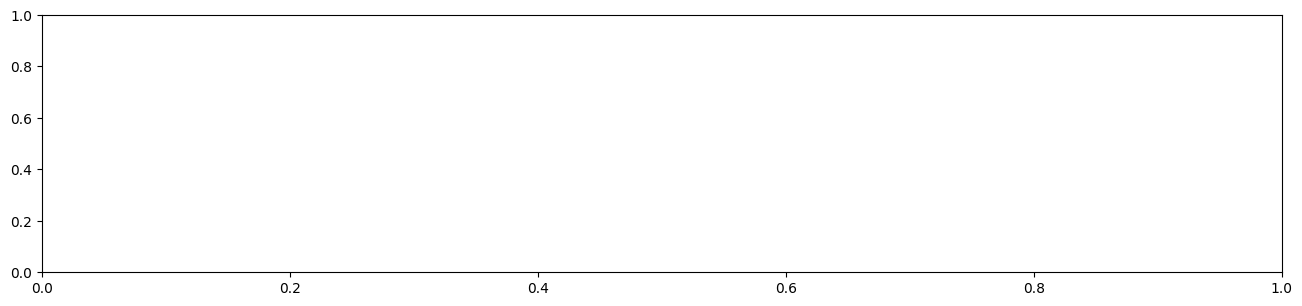

In [33]:
#show_grad_cam_cnn(images, model)
#save_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_grad_cam/advanced_model"
save_path = "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_grad_cam/advanced_model"

#show_grad_cam_cnn(images, labels, model, class_names, save_dir=save_path) #für 4 bilder 

show_grad_cam_cnn(all_images, all_labels, model, class_names, save_dir=save_path) #für alle bilder


In [24]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from collections import defaultdict

def explain_and_save_overlay_per_class(
    model,
    dataset,                 # tf.data.Dataset
    class_names,
    save_dir,
    max_evals=500,
    samples_per_class=2
):
    os.makedirs(save_dir, exist_ok=True)

    # Bilder pro Klasse sammeln
    collected = defaultdict(list)

    for image, label in dataset.unbatch():
        label_index = int(label.numpy())
        if len(collected[label_index]) < samples_per_class:
            collected[label_index].append(image.numpy())
        # Stop early if all classes are full
        if all(len(v) >= samples_per_class for v in collected.values()):
            break

    # Pro Klasse SHAP generieren
    for class_index, images in collected.items():
        class_name = class_names[class_index]
        images = np.stack(images, axis=0)

        print(f"\n🔍 Klasse: {class_name} | Anzahl Bilder: {len(images)}")

        # SHAP-Erklärer
        masker = shap.maskers.Image("inpaint_telea", images[0].shape)
        explainer = shap.Explainer(model, masker, output_names=class_names)

        shap_values = explainer(
            images,
            max_evals=max_evals,
            outputs=shap.Explanation.argsort.flip[:1]
        )

        for i, shap_exp in enumerate(shap_values):
            img = images[i]

            shap_val = shap_exp.values
            if isinstance(shap_val, list):
                shap_val = shap_val[0]

            while shap_val.ndim > 3:
                shap_val = np.squeeze(shap_val, axis=-1)

            if shap_val.shape != img.shape:
                print(f"❌ Shape mismatch: {shap_val.shape} vs {img.shape}")
                continue

            # SHAP-Karte mitteln (H, W)
            shap_overlay = shap_val.mean(axis=-1)

            # Normalisieren
            shap_norm = (shap_overlay - shap_overlay.min()) / (shap_overlay.ptp() + 1e-8)
            cmap = plt.get_cmap("bwr")
            heatmap = cmap(shap_norm)[:, :, :3]

            img_float = img.astype(np.float32) / 255.0
            overlay = (0.6 * img_float + 0.4 * heatmap).clip(0, 1)

            # Speichern
            safe_class_name = class_name.replace('/', '_').replace(' ', '_')
            overlay_path = os.path.join(save_dir, f"{safe_class_name}_img{i+1}_overlay.png")
            original_path = os.path.join(save_dir, f"{safe_class_name}_img{i+1}_original.png")

            Image.fromarray((overlay * 255).astype(np.uint8)).save(overlay_path)
            Image.fromarray(img.astype(np.uint8)).save(original_path)

            print(f"✅ Gespeichert: {overlay_path}")
            print(f"✅ Gespeichert: {original_path}")


In [25]:
#save_path_shap = r"C:\Users\Alex\Documents\GitHub\may25_bds_plants\04_src\images_shap\first_model_2025_07_29"
save_path_shap =  "/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model"


explain_and_save_overlay_per_class(
    model=model,
    dataset=dataset_valid,
    class_names=class_names,
    save_dir=save_path_shap,
    max_evals=500,
    samples_per_class=2  # 2 Bilder pro Klasse
)


🔍 Klasse: Corn_(maize)___healthy | Anzahl Bilder: 2


/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/0

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(2, 224, 224, 3))
  warnings.warn(msg)
/Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_15']
Received: inputs=Tensor(shape=(8, 224, 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:57, 28.63s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___healthy_img2_original.png

🔍 Klasse: Tomato___Tomato_mosaic_virus | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:52, 26.49s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_mosaic_virus_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_mosaic_virus_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_mosaic_virus_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_mosaic_virus_img2_original.png

🔍 Klasse: Tomato___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:37, 18.70s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Bacterial_spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Bacterial_spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Bacterial_spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Bacterial_spot_img2_original.png

🔍 Klasse: Squash___Powdery_mildew | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:47, 23.96s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Squash___Powdery_mildew_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Squash___Powdery_mildew_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Squash___Powdery_mildew_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Squash___Powdery_mildew_img2_original.png

🔍 Klasse: Grape___Esca_(Black_Measles) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:41, 20.70s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Esca_(Black_Measles)_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Esca_(Black_Measles)_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Esca_(Black_Measles)_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Esca_(Black_Measles)_img2_original.png

🔍 Klasse: Peach___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:51, 25.77s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___Bacterial_spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___Bacterial_spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___Bacterial_spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___Bacterial_spot_img2_original.png

🔍 Klasse: Cherry_(including_sour)___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:44, 22.29s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___healthy_img2_original.png

🔍 Klasse: Tomato___Late_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:52, 26.45s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Late_blight_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Late_blight_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Late_blight_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Late_blight_img2_original.png

🔍 Klasse: Tomato___Early_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:39, 19.78s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Early_blight_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Early_blight_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Early_blight_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Early_blight_img2_original.png

🔍 Klasse: Peach___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:45, 22.99s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Peach___healthy_img2_original.png

🔍 Klasse: Corn_(maize)___Northern_Leaf_Blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:47, 23.78s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Northern_Leaf_Blight_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Northern_Leaf_Blight_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Northern_Leaf_Blight_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Northern_Leaf_Blight_img2_original.png

🔍 Klasse: Tomato___Spider_mites Two-spotted_spider_mite | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:46, 23.12s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Spider_mites_Two-spotted_spider_mite_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Spider_mites_Two-spotted_spider_mite_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Spider_mites_Two-spotted_spider_mite_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Spider_mites_Two-spotted_spider_mite_img2_original.png

🔍 Klasse: Pepper,_bell___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:46, 23.25s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___healthy_img2_original.png

🔍 Klasse: Tomato___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:43, 21.57s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___healthy_img2_original.png

🔍 Klasse: Strawberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:44, 22.32s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___healthy_img2_original.png

🔍 Klasse: Tomato___Leaf_Mold | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:45, 22.68s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Leaf_Mold_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Leaf_Mold_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Leaf_Mold_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Leaf_Mold_img2_original.png

🔍 Klasse: Potato___Early_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:46, 23.41s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Early_blight_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Early_blight_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Early_blight_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Early_blight_img2_original.png

🔍 Klasse: Grape___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:45, 22.65s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___healthy_img2_original.png

🔍 Klasse: Soybean___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:40, 20.12s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Soybean___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Soybean___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Soybean___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Soybean___healthy_img2_original.png

🔍 Klasse: Grape___Black_rot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:44, 22.45s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Black_rot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Black_rot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Black_rot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Black_rot_img2_original.png

🔍 Klasse: Corn_(maize)___Common_rust_ | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:50, 25.06s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Common_rust__img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Common_rust__img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Common_rust__img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Common_rust__img2_original.png

🔍 Klasse: Tomato___Tomato_Yellow_Leaf_Curl_Virus | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:44, 22.35s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_Yellow_Leaf_Curl_Virus_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_Yellow_Leaf_Curl_Virus_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_Yellow_Leaf_Curl_Virus_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Tomato_Yellow_Leaf_Curl_Virus_img2_original.png

🔍 Klasse: Potato___Late_blight | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:37, 18.68s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Late_blight_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Late_blight_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Late_blight_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___Late_blight_img2_original.png

🔍 Klasse: Apple___Apple_scab | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:48, 24.29s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Apple_scab_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Apple_scab_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Apple_scab_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Apple_scab_img2_original.png

🔍 Klasse: Orange___Haunglongbing_(Citrus_greening) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:43, 21.82s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Orange___Haunglongbing_(Citrus_greening)_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Orange___Haunglongbing_(Citrus_greening)_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Orange___Haunglongbing_(Citrus_greening)_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Orange___Haunglongbing_(Citrus_greening)_img2_original.png

🔍 Klasse: Tomato___Target_Spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:41, 20.64s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Target_Spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Target_Spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Target_Spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Target_Spot_img2_original.png

🔍 Klasse: Tomato___Septoria_leaf_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:47, 23.52s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Septoria_leaf_spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Septoria_leaf_spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Septoria_leaf_spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Tomato___Septoria_leaf_spot_img2_original.png

🔍 Klasse: Pepper,_bell___Bacterial_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:42, 21.39s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___Bacterial_spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___Bacterial_spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___Bacterial_spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Pepper,_bell___Bacterial_spot_img2_original.png

🔍 Klasse: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:46, 23.08s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Corn_(maize)___Cercospora_leaf_spot_Gray_leaf_spot_img2_original.png

🔍 Klasse: Apple___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:50, 25.24s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___healthy_img2_original.png

🔍 Klasse: Cherry_(including_sour)___Powdery_mildew | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:49, 24.75s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___Powdery_mildew_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___Powdery_mildew_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___Powdery_mildew_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Cherry_(including_sour)___Powdery_mildew_img2_original.png

🔍 Klasse: Strawberry___Leaf_scorch | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:45, 22.64s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___Leaf_scorch_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___Leaf_scorch_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___Leaf_scorch_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Strawberry___Leaf_scorch_img2_original.png

🔍 Klasse: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:45, 22.64s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)_img2_original.png

🔍 Klasse: Potato___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:44, 22.01s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Potato___healthy_img2_original.png

🔍 Klasse: Apple___Black_rot | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:47, 23.51s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Black_rot_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Black_rot_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Black_rot_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Black_rot_img2_original.png

🔍 Klasse: Apple___Cedar_apple_rust | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:52, 26.13s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Cedar_apple_rust_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Cedar_apple_rust_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Cedar_apple_rust_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Apple___Cedar_apple_rust_img2_original.png

🔍 Klasse: Raspberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:48, 24.14s/it]               


✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Raspberry___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Raspberry___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Raspberry___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Raspberry___healthy_img2_original.png

🔍 Klasse: Blueberry___healthy | Anzahl Bilder: 2


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:49, 24.67s/it]               

✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Blueberry___healthy_img1_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Blueberry___healthy_img1_original.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Blueberry___healthy_img2_overlay.png
✅ Gespeichert: /Users/felix/Documents/Data Science/06_Offical_project_DS/may25_bds_plants/04_src/images_shap/advanced_model/Blueberry___healthy_img2_original.png
